# Калибровка для многоклассовой классификации

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.calibration import IsotonicRegression, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss, classification_report
from sklearn.preprocessing import normalize

import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [59]:
x, y = make_classification(
    n_samples=700000,
    n_features=10,
    n_informative=5,
    n_classes=4,
    class_sep=0.6,
    weights=[0.7, 0.2, 0.05, 0.05],
    random_state=42)

In [60]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True, stratify=y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=True, stratify=y_train)

In [61]:
x_train.shape, x_val.shape, x_test.shape

((505750, 10), (105000, 10), (89250, 10))

In [62]:
model = LGBMClassifier(class_weight='balanced')
model.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 505750, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced')

In [63]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     73010
           1       0.73      0.73      0.73     21066
           2       0.38      0.82      0.52      5455
           3       0.37      0.64      0.47      5469

    accuracy                           0.78    105000
   macro avg       0.60      0.75      0.65    105000
weighted avg       0.84      0.78      0.80    105000



In [64]:
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     62059
           1       0.74      0.72      0.73     17906
           2       0.38      0.82      0.52      4636
           3       0.36      0.64      0.46      4649

    accuracy                           0.78     89250
   macro avg       0.61      0.75      0.65     89250
weighted avg       0.84      0.78      0.80     89250



In [65]:
def give_ece_data(preds, bins, y_valid):
    sorted_ind = np.argsort(preds)
    predicted_bins = [[] for _ in range(bins)]
    actual_counters = [[] for _ in range(bins)]
    counters = [[] for _ in range(bins)]
    
    index = 0
    length_array = len(sorted_ind)
    step = 1.*length_array//bins
    
    for _ in range(bins):
        current = int(step*index)
        next_ = int(step*(index+1))
        
        predicted_bins[index] = np.mean(preds[sorted_ind[current:next_]])
        actual_counters[index] = np.mean(y_valid[sorted_ind[current:next_]])
        counters[index] = len(y_valid[sorted_ind[current:next_]])
        
        index += 1
    return predicted_bins, actual_counters, counters

def calc_ece(predicted_bins, actual_counters, counters, bins, len_y):
    """Calculate Expected Calibration Error"""
    ece = 0
    for i in range(bins):
        ece += counters[i] * np.abs((predicted_bins[i] - actual_counters[i]))
    ece /= len_y
    return ece

In [66]:
val_preds = model.predict_proba(x_val)

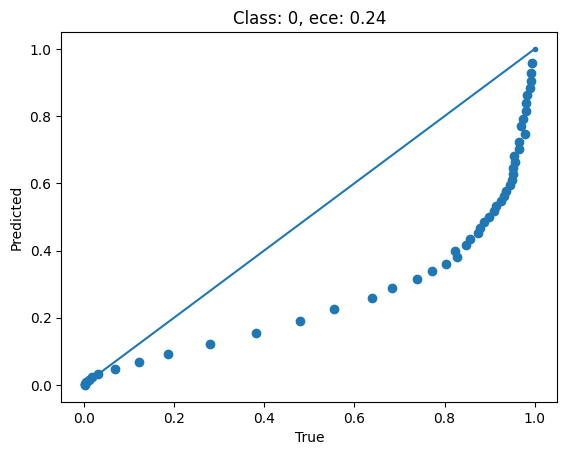

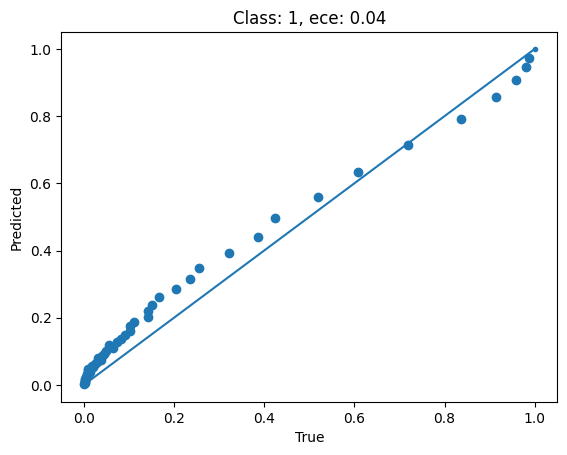

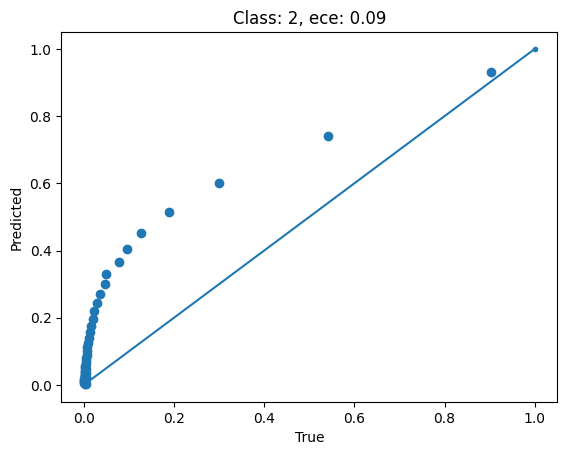

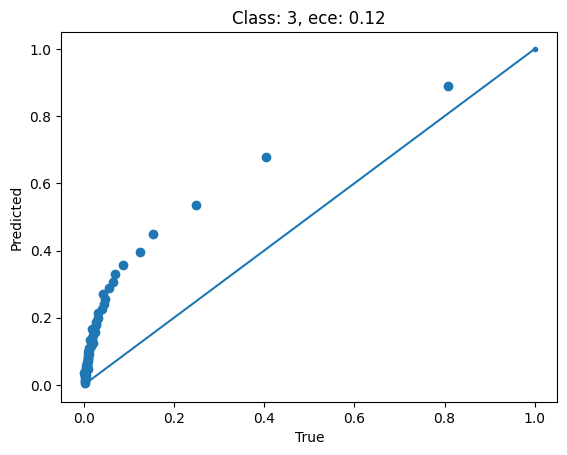

In [67]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = val_preds[:, class_]
    y = (y_val == class_).astype(int)
    
    predicted_bins, actual_counters, counters = give_ece_data(preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [68]:
print(log_loss(y_val, val_preds))
for class_ in [0, 1, 2, 3]:
    print(f"Class: {class_}, brier score: {brier_score_loss((y_val == class_).astype(int), val_preds[:, class_])}")

0.6326886553020482
Class: 0, brier score: 0.1662755889781911
Class: 1, brier score: 0.07692765254826382
Class: 2, brier score: 0.04552978728708822
Class: 3, brier score: 0.05352846988806336


# Калибровка

## OneVsAll

In [69]:
class OneVsAllIsotonicCalibrator:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.models = [IsotonicRegression(out_of_bounds='clip') for _ in range(n_classes)]
        
    def fit(self, scores, ys):
        for i in range(self.n_classes):
            model = self.models[i]
            preds = scores[:, i]
            y = ys[:, i]
            model.fit(preds, y)
        return self
    
    def predict_proba(self, scores):
        probs = np.zeros(shape=[scores.shape[0], self.n_classes])
        for i in range(self.n_classes):
            model = self.models[i]
            preds = scores[:, i]
            prob = model.predict(preds)
            probs[:, i] = prob
            
        probs = normalize(probs, norm='l1', axis=1)
        probs = np.clip(probs, a_min=0, a_max=1)
        return probs

In [70]:
iso_calib = OneVsAllIsotonicCalibrator(n_classes=4)

In [71]:
scores = val_preds
ys = pd.get_dummies(y_val).astype(int).values

iso_calib.fit(scores, ys)

In [72]:
val_probs = iso_calib.predict_proba(scores)

Predicted: 0.4495 <= 0.4513 <= 0.4530
True: 0.6953
Calibrated: 0.6726 <= 0.6747 <= 0.6768


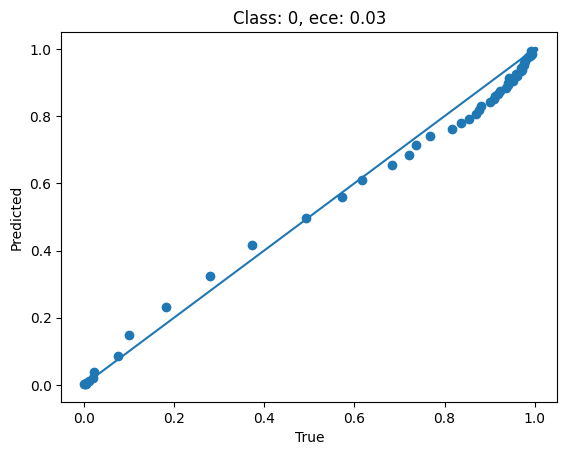

Predicted: 0.2337 <= 0.2354 <= 0.2370
True: 0.2006
Calibrated: 0.1999 <= 0.2017 <= 0.2035


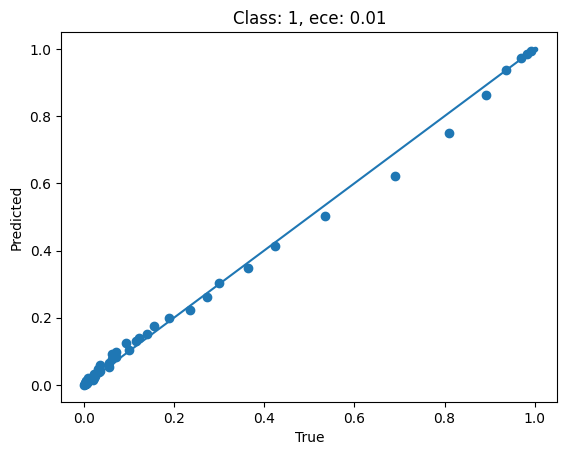

Predicted: 0.1443 <= 0.1455 <= 0.1467
True: 0.0520
Calibrated: 0.0593 <= 0.0604 <= 0.0615


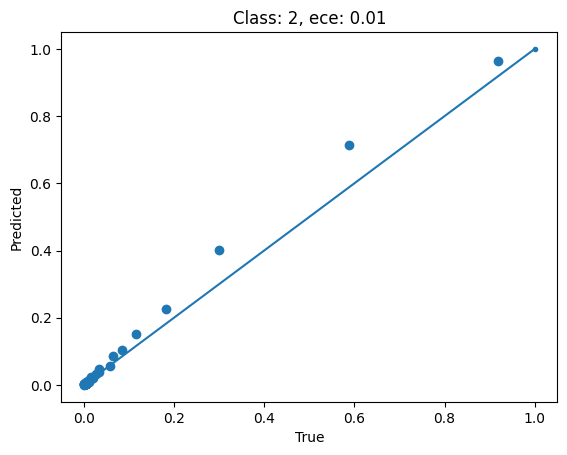

Predicted: 0.1668 <= 0.1679 <= 0.1689
True: 0.0521
Calibrated: 0.0622 <= 0.0632 <= 0.0642


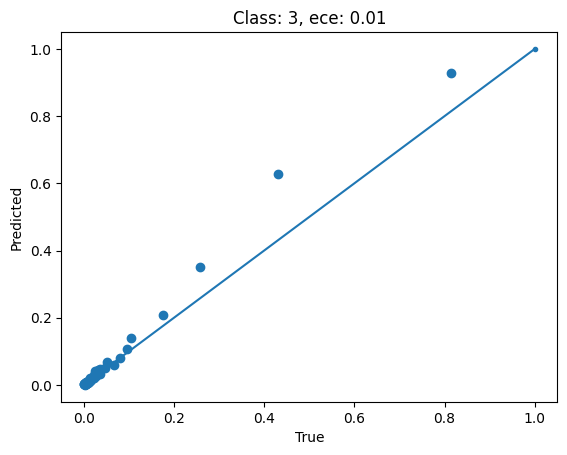

In [73]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = val_preds[:, class_]
    y = (y_val == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = val_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [74]:
print(log_loss(y_val, val_probs))
for class_ in [0, 1, 2, 3]:
    print(f"Class: {class_}, brier score: {brier_score_loss((y_val == class_).astype(int), val_probs[:, class_])}")

0.4001315709704849
Class: 0, brier score: 0.08207186651221901
Class: 1, brier score: 0.06742216655473396
Class: 2, brier score: 0.025215901686890405
Class: 3, brier score: 0.033198945350140195


In [75]:
print(classification_report(y_val, np.argmax(val_probs, axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.92     73010
           1       0.86      0.67      0.75     21066
           2       0.71      0.62      0.66      5455
           3       0.61      0.49      0.54      5469

    accuracy                           0.86    105000
   macro avg       0.77      0.69      0.72    105000
weighted avg       0.86      0.86      0.86    105000



### OOS

In [76]:
test_preds = model.predict_proba(x_test)
test_probs = iso_calib.predict_proba(test_preds)

Predicted: 0.4507 <= 0.4526 <= 0.4545
True: 0.6953
Calibrated: 0.6745 <= 0.6767 <= 0.6790


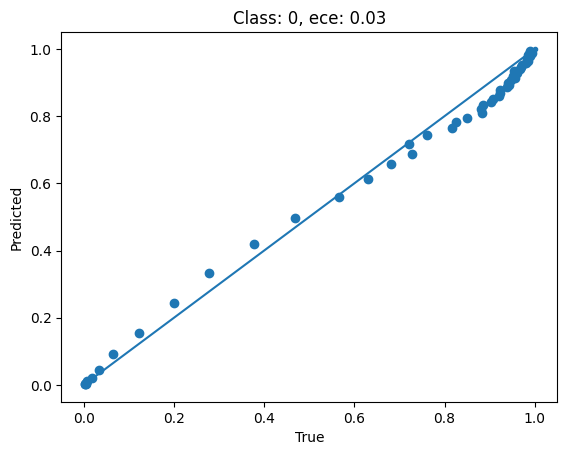

Predicted: 0.2309 <= 0.2327 <= 0.2345
True: 0.2006
Calibrated: 0.1971 <= 0.1991 <= 0.2010


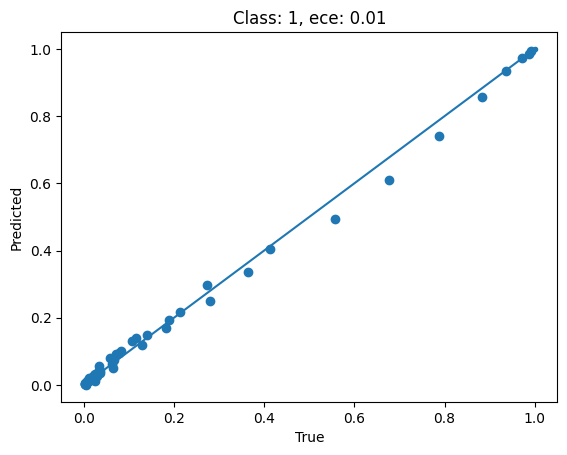

Predicted: 0.1446 <= 0.1460 <= 0.1473
True: 0.0519
Calibrated: 0.0595 <= 0.0606 <= 0.0618


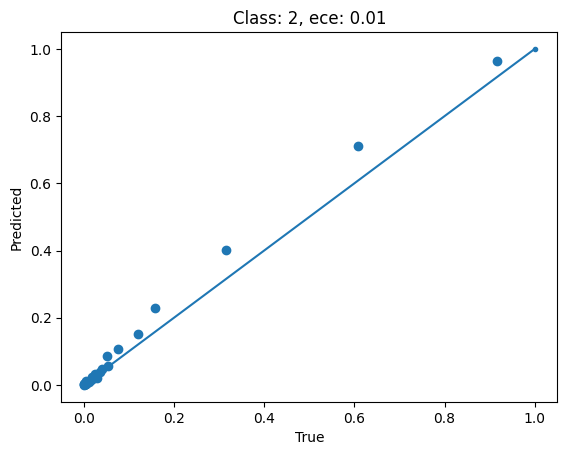

Predicted: 0.1676 <= 0.1687 <= 0.1699
True: 0.0521
Calibrated: 0.0625 <= 0.0636 <= 0.0646


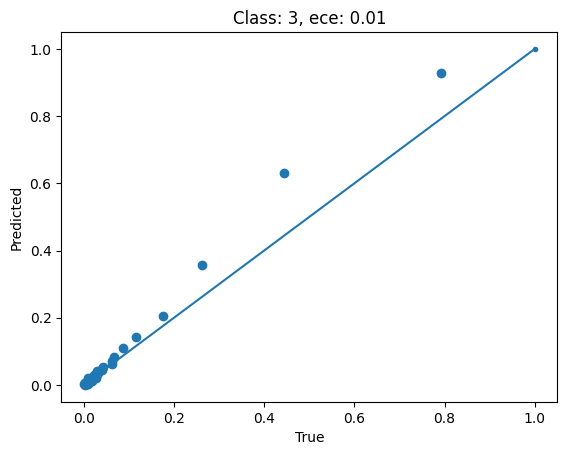

In [77]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = test_preds[:, class_]
    y = (y_test == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = test_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

## LogReg

In [78]:
def transform(x):
    return np.log(x/(1-x))

In [79]:
reg = LogisticRegression()
reg.fit(transform(val_preds), y_val)

LogisticRegression()

In [80]:
val_probs = reg.predict_proba(transform(val_preds))

Predicted: 0.4495 <= 0.4513 <= 0.4530
True: 0.6953
Calibrated: 0.6932 <= 0.6953 <= 0.6975


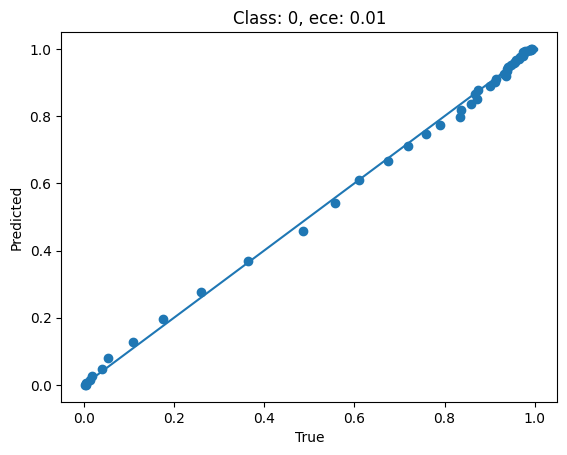

Predicted: 0.2337 <= 0.2354 <= 0.2370
True: 0.2006
Calibrated: 0.1988 <= 0.2006 <= 0.2025


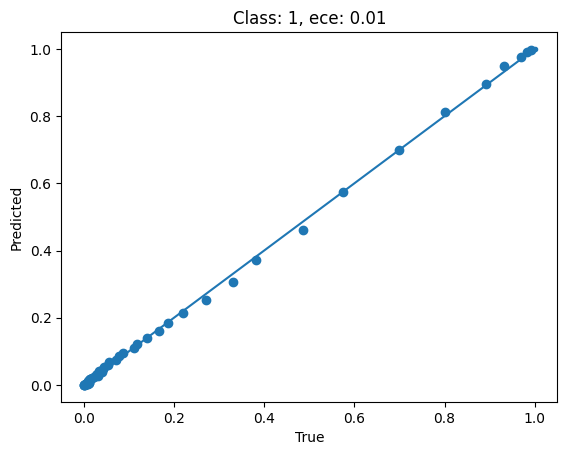

Predicted: 0.1443 <= 0.1455 <= 0.1467
True: 0.0520
Calibrated: 0.0510 <= 0.0520 <= 0.0529


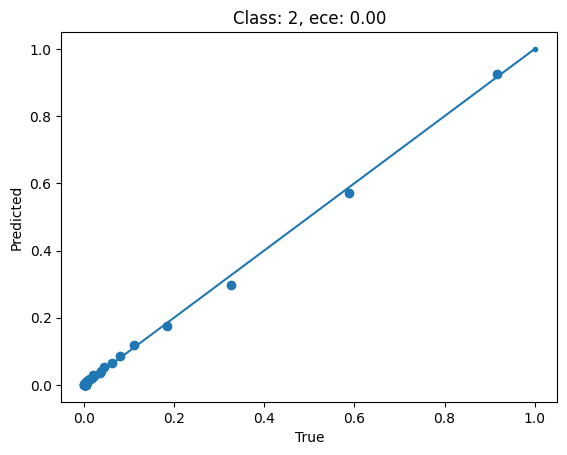

Predicted: 0.1668 <= 0.1679 <= 0.1689
True: 0.0521
Calibrated: 0.0513 <= 0.0521 <= 0.0529


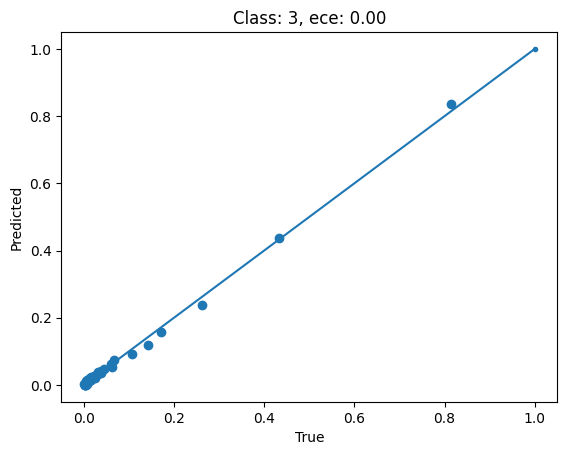

In [81]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = val_preds[:, class_]
    y = (y_val == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = val_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [82]:
print(log_loss(y_val, val_probs))
for class_ in [0, 1, 2, 3]:
    print(f"Class: {class_}, brier score: {brier_score_loss((y_val == class_).astype(int), val_probs[:, class_])}")

0.39051441388749447
Class: 0, brier score: 0.08014862994392032
Class: 1, brier score: 0.06520584736312249
Class: 2, brier score: 0.024465624365836186
Class: 3, brier score: 0.03165692138902214


## Calibration Trees One Vs All

In [83]:
class OneVsAllTreeCalibrator:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.models = [DecisionTreeClassifier(min_samples_leaf=2500, max_depth=6) for _ in range(n_classes)]
        self.logregs = {}
        
    @staticmethod
    def transform(x):
        return np.log(x/(1-x))
        
    def fit(self, x_train, y_train, x_val, y_val, scores):
        for i in range(self.n_classes):
            y_tr = (y_train == i).astype(int)
            y_vl = (y_val == i).astype(int)
            sc = scores[:, i].reshape(-1, 1)
            
            tree = self.models[i]
            tree.fit(x_train, y_tr)  # обучаем на исходных данных
            
            TREE = tree.tree_
            # находим в какой ноде будет каждый элемент валидационного сета
            indexes = TREE.apply(x_val.astype(np.float32))
            
            log_reg_dict = {}
            nodes = np.unique(indexes)  # для каждой ноды обучем логистическую регрессию
            for node in nodes:
                log_reg = LogisticRegression()
                log_reg.fit(self.transform(sc[indexes==node]), y_vl[indexes==node])  # обучаем только на тех, которые попали в этот лист
                log_reg_dict[node] = log_reg
            
            self.logregs[i] = log_reg_dict
            
        return self
    
    def predict_proba(self, x, scores):
        probs = np.zeros(shape=[scores.shape[0], self.n_classes])
        for i in range(self.n_classes):
            predicts_from_model = scores[:, i].reshape(-1, 1)
            predicts_calibrated = np.zeros_like(predicts_from_model)
            
            TREE = self.models[i].tree_
            indexes = TREE.apply(x.astype(np.float32))
            
            log_reg_dict = self.logregs[i]

            for node in log_reg_dict.keys():
                predicts_calibrated[indexes==node] = log_reg_dict[node].\
                    predict_proba(self.transform(predicts_from_model[indexes==node]))[:, 1].reshape((-1, 1))
            
            probs[:, i] = predicts_calibrated.ravel()
            
        probs = normalize(probs, norm='l1', axis=1)
        probs = np.clip(probs, a_min=0, a_max=1)
        return probs

In [84]:
tree_calib = OneVsAllTreeCalibrator(4)

In [85]:
tree_calib.fit(x_train, y_train, x_val, y_val, val_preds)

In [86]:
val_probs = tree_calib.predict_proba(x_val, val_preds)

Predicted: 0.4495 <= 0.4513 <= 0.4530
True: 0.6953
Calibrated: 0.6804 <= 0.6825 <= 0.6846


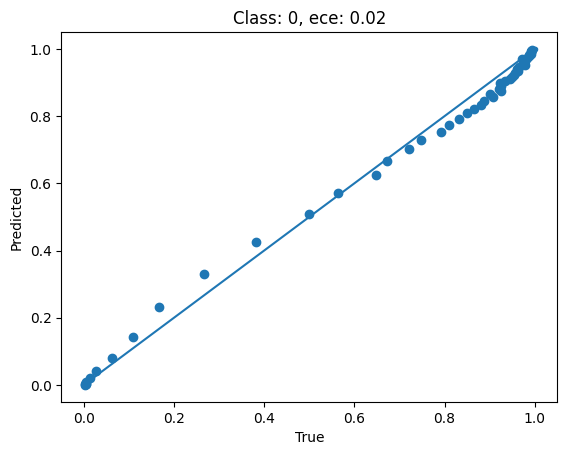

Predicted: 0.2337 <= 0.2354 <= 0.2370
True: 0.2006
Calibrated: 0.1993 <= 0.2011 <= 0.2030


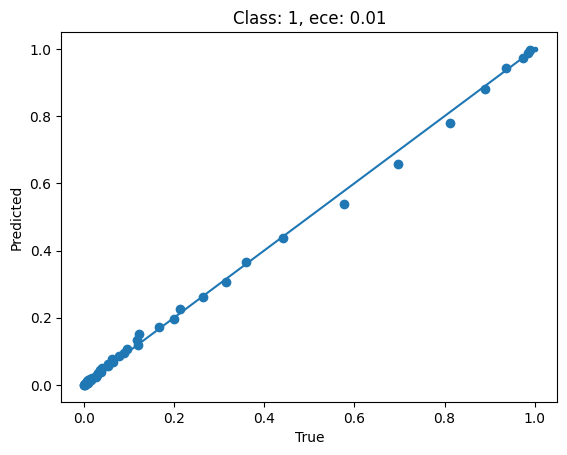

Predicted: 0.1443 <= 0.1455 <= 0.1467
True: 0.0520
Calibrated: 0.0574 <= 0.0584 <= 0.0594


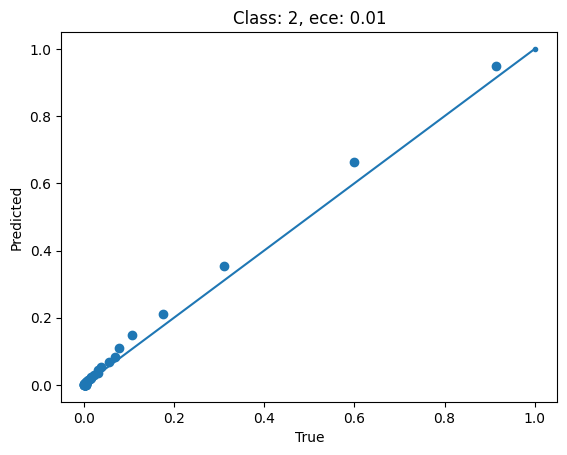

Predicted: 0.1668 <= 0.1679 <= 0.1689
True: 0.0521
Calibrated: 0.0571 <= 0.0579 <= 0.0588


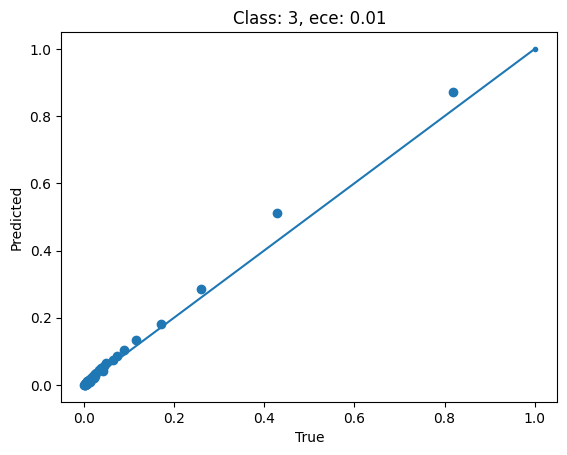

In [87]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = val_preds[:, class_]
    y = (y_val == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = val_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [88]:
print(log_loss(y_val, val_probs))
for class_ in [0, 1, 2, 3]:
    print(f"Class: {class_}, brier score: {brier_score_loss((y_val == class_).astype(int), val_probs[:, class_])}")

0.39386516360753865
Class: 0, brier score: 0.08081055583115354
Class: 1, brier score: 0.06579542806993433
Class: 2, brier score: 0.02477205835215308
Class: 3, brier score: 0.03194511858922674


In [89]:
print(classification_report(y_val, np.argmax(val_probs, axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     73010
           1       0.85      0.69      0.76     21066
           2       0.74      0.60      0.66      5455
           3       0.66      0.44      0.53      5469

    accuracy                           0.87    105000
   macro avg       0.79      0.67      0.72    105000
weighted avg       0.86      0.87      0.86    105000



### OOS

In [90]:
test_preds = model.predict_proba(x_test)
test_probs = tree_calib.predict_proba(x_test, test_preds)

Predicted: 0.4507 <= 0.4526 <= 0.4545
True: 0.6953
Calibrated: 0.6820 <= 0.6843 <= 0.6866


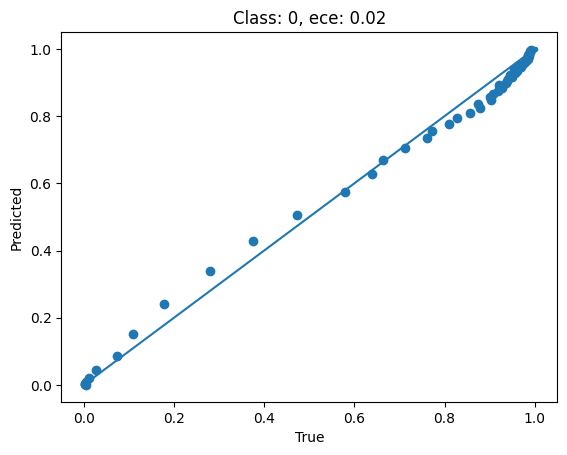

Predicted: 0.2309 <= 0.2327 <= 0.2345
True: 0.2006
Calibrated: 0.1965 <= 0.1985 <= 0.2005


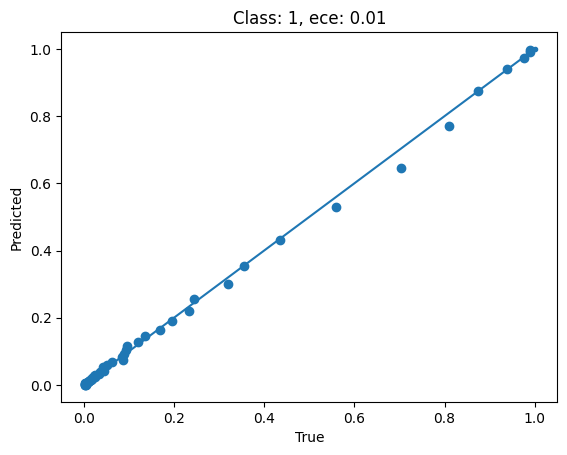

Predicted: 0.1446 <= 0.1460 <= 0.1473
True: 0.0519
Calibrated: 0.0577 <= 0.0588 <= 0.0599


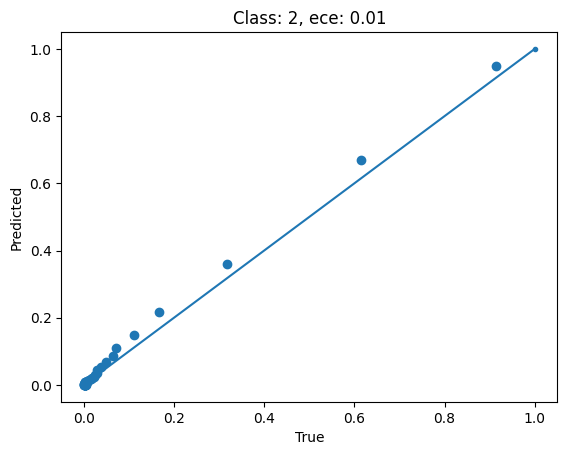

Predicted: 0.1676 <= 0.1687 <= 0.1699
True: 0.0521
Calibrated: 0.0574 <= 0.0584 <= 0.0593


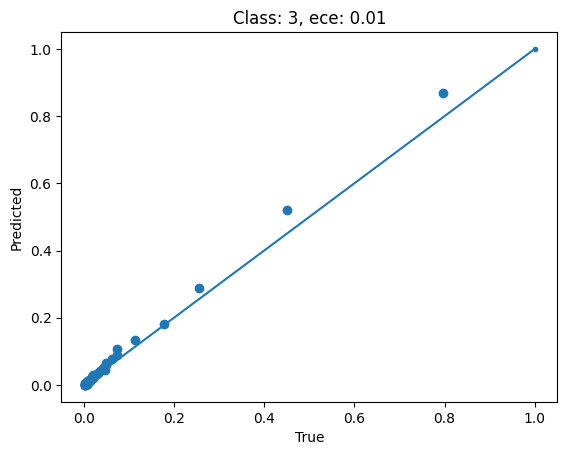

In [91]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = test_preds[:, class_]
    y = (y_test == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = test_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [92]:
print(classification_report(y_test, np.argmax(test_probs, axis=-1)))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     62059
           1       0.85      0.68      0.76     17906
           2       0.75      0.61      0.67      4636
           3       0.66      0.44      0.53      4649

    accuracy                           0.87     89250
   macro avg       0.78      0.68      0.72     89250
weighted avg       0.86      0.87      0.86     89250



## Calibration Trees Directly

In [93]:
class TreeCalibrator:
    def __init__(self):
        self.log_reg_dict = {}
        self.tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2500)
        
    @staticmethod
    def transform(x):
        return np.log(x/(1-x))
        
    def fit(self, x_train, y_train, x_val, y_val, scores):
        self.tree.fit(x_train, y_train)  # обучаем на исходных данных

        TREE = self.tree.tree_
        # находим в какой ноде будет каждый элемент валидационного сета
        indexes = TREE.apply(x_val.astype(np.float32))

        nodes = np.unique(indexes)  # для каждой ноды обучем логистическую регрессию
        for node in nodes:
            log_reg = LogisticRegression()
            # обучаем только на тех, которые попали в этот лист
            log_reg.fit(self.transform(scores[indexes==node]), y_val[indexes==node])
            self.log_reg_dict[node] = log_reg
            
        return self
    
    def predict_proba(self, x, scores):
        probs = np.zeros_like(scores)

        TREE = self.tree.tree_
        indexes = TREE.apply(x.astype(np.float32))

        for node in self.log_reg_dict.keys():
            probs[indexes==node] = self.log_reg_dict[node].\
                predict_proba(self.transform(scores[indexes==node]))
            
        probs = normalize(probs, norm='l1', axis=1)
        probs = np.clip(probs, a_min=0, a_max=1)
        return probs

In [94]:
tree_calib_multiclass = TreeCalibrator()

In [95]:
tree_calib_multiclass.fit(x_train, y_train, x_val, y_val, val_preds)

/home/roman/MyProjects/Data Science/uplift/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/roman/MyProjects/Data Science/uplift/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

In [96]:
val_probs = tree_calib_multiclass.predict_proba(x_val, val_preds)

Predicted: 0.4495 <= 0.4513 <= 0.4530
True: 0.6953
Calibrated: 0.6932 <= 0.6954 <= 0.6976


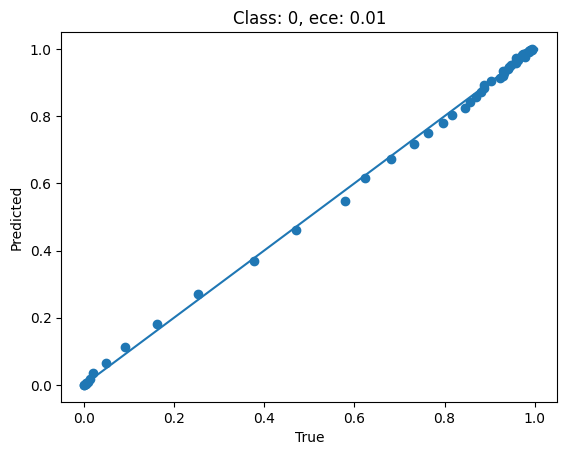

Predicted: 0.2337 <= 0.2354 <= 0.2370
True: 0.2006
Calibrated: 0.1987 <= 0.2006 <= 0.2025


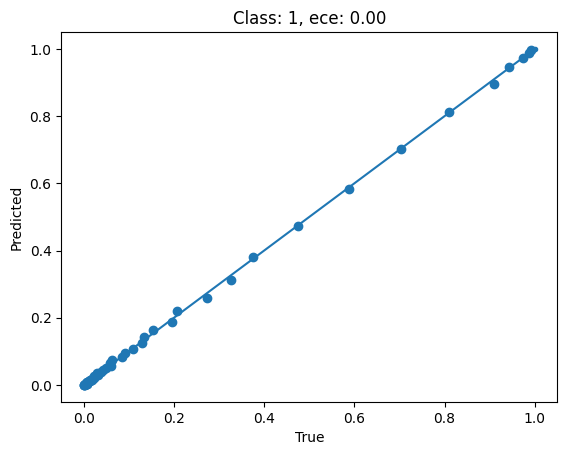

Predicted: 0.1443 <= 0.1455 <= 0.1467
True: 0.0520
Calibrated: 0.0510 <= 0.0520 <= 0.0529


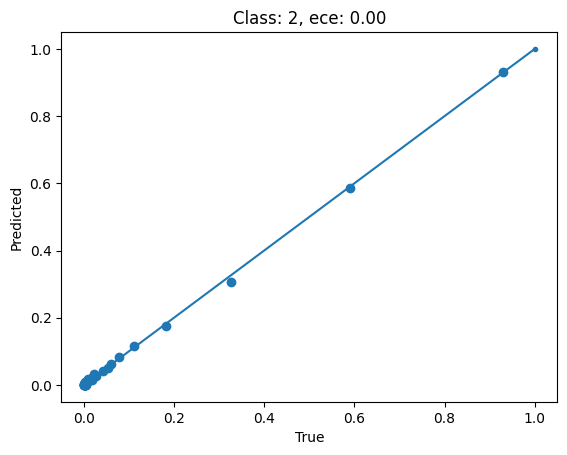

Predicted: 0.1668 <= 0.1679 <= 0.1689
True: 0.0521
Calibrated: 0.0512 <= 0.0521 <= 0.0529


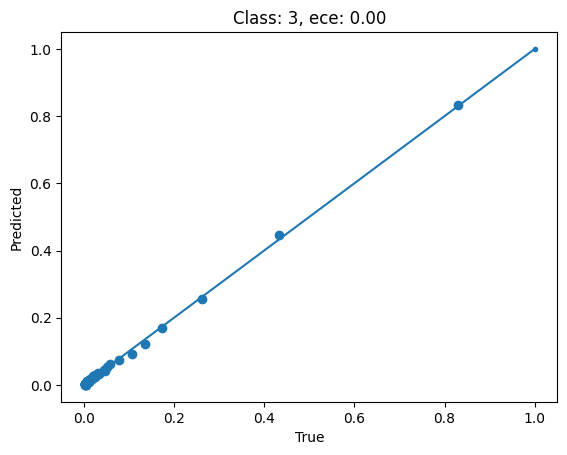

In [97]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = val_preds[:, class_]
    y = (y_val == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = val_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [98]:
print(log_loss(y_val, val_probs))
for class_ in [0, 1, 2, 3]:
    print(f"Class: {class_}, brier score: {brier_score_loss((y_val == class_).astype(int), val_probs[:, class_])}")

0.3793903673052856
Class: 0, brier score: 0.07817257820432313
Class: 1, brier score: 0.06358498759783755
Class: 2, brier score: 0.023922155347077475
Class: 3, brier score: 0.03114473149880936


In [99]:
print(classification_report(y_val, np.argmax(val_probs, axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     73010
           1       0.83      0.72      0.77     21066
           2       0.75      0.59      0.66      5455
           3       0.70      0.42      0.53      5469

    accuracy                           0.87    105000
   macro avg       0.80      0.68      0.72    105000
weighted avg       0.86      0.87      0.86    105000



### OOS

In [100]:
test_preds = model.predict_proba(x_test)
test_probs = tree_calib_multiclass.predict_proba(x_test, test_preds)

Predicted: 0.4507 <= 0.4526 <= 0.4545
True: 0.6953
Calibrated: 0.6951 <= 0.6975 <= 0.6999


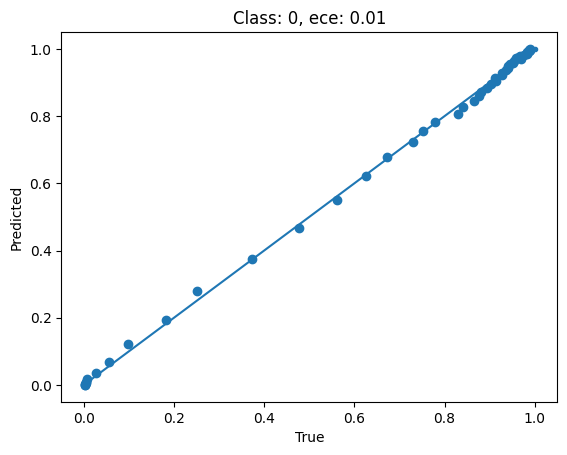

Predicted: 0.2309 <= 0.2327 <= 0.2345
True: 0.2006
Calibrated: 0.1960 <= 0.1980 <= 0.2000


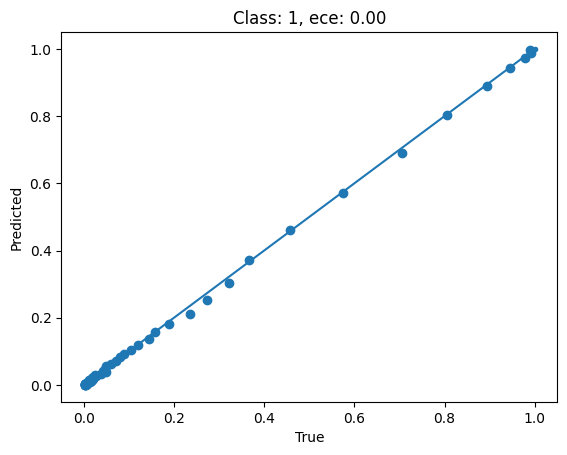

Predicted: 0.1446 <= 0.1460 <= 0.1473
True: 0.0519
Calibrated: 0.0511 <= 0.0522 <= 0.0532


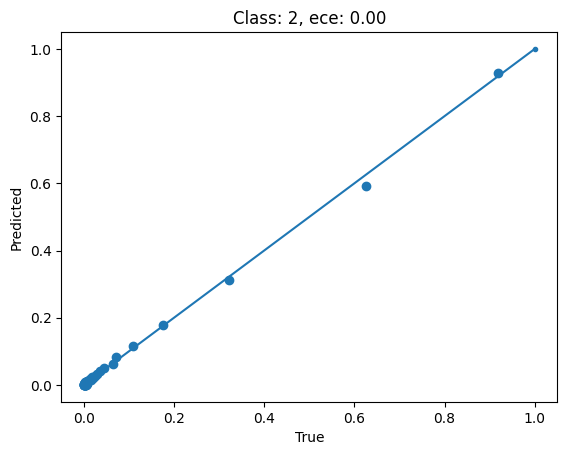

Predicted: 0.1676 <= 0.1687 <= 0.1699
True: 0.0521
Calibrated: 0.0514 <= 0.0523 <= 0.0532


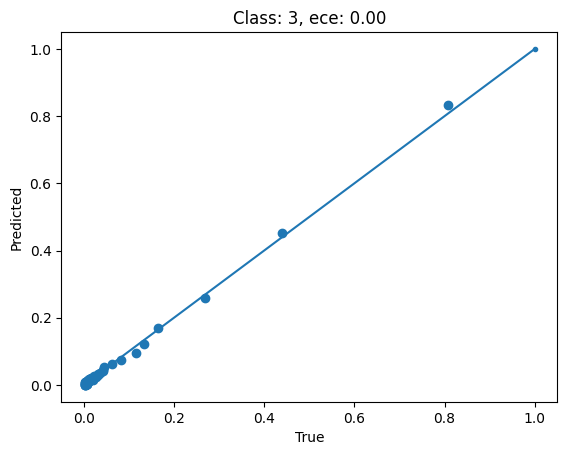

In [101]:
n_bins = 50

for class_ in [0, 1, 2, 3]:  # разные классы, калибровка для каждого в отдельности
    preds = test_preds[:, class_]
    y = (y_test == class_).astype(int)
    
    left, right = sts.norm.interval(0.95, loc=preds.mean(), scale=preds.std()/np.sqrt(len(preds)))
    
    print(f"Predicted: {left:.4f} <= {preds.mean():.4f} <= {right:.4f}")
    print(f"True: {y.mean():.4f}")
    
    calibrated_preds = test_probs[:, class_]
    left, right = sts.norm.interval(0.95, loc=calibrated_preds.mean(),
                                    scale=calibrated_preds.std()/np.sqrt(len(preds)))
    print(f"Calibrated: {left:.4f} <= {calibrated_preds.mean():.4f} <= {right:.4f}")
    
    predicted_bins, actual_counters, counters = give_ece_data(calibrated_preds, n_bins, y)
    
    ece = calc_ece(predicted_bins, actual_counters, counters, n_bins, y.shape[0])
    plt.title(f"Class: {class_}, ece: {ece:.2f}")
    plt.plot([0, 1], [0, 1], '.-')
    plt.scatter(actual_counters, predicted_bins)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.pause(0.01)

In [102]:
print(log_loss(y_test, test_probs))
for class_ in [0, 1, 2, 3]:
    print(f"Class: {class_}, brier score: {brier_score_loss((y_test == class_).astype(int), test_probs[:, class_])}")

0.38379209832396827
Class: 0, brier score: 0.07864874984275268
Class: 1, brier score: 0.06436016719630723
Class: 2, brier score: 0.023584339409533656
Class: 3, brier score: 0.03167662271958931


In [103]:
print(classification_report(y_test, np.argmax(test_probs, axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     62059
           1       0.84      0.71      0.77     17906
           2       0.76      0.61      0.68      4636
           3       0.69      0.42      0.52      4649

    accuracy                           0.87     89250
   macro avg       0.79      0.68      0.72     89250
weighted avg       0.86      0.87      0.86     89250

